# Pergunta 01

- Verifique se a variação da conversão foi estatisticamente significativa, para cada um dos estados em que houve o teste. 

- Para a ação de frete ser considerada bem-sucedida, o ROI do investimento em frete deve ser maior que 13, ou seja, para cada 1 real investido, deve-se ter, em contrapartida, 13 reais de retorno incremental em vendas. Com base nesta meta, avalie se o teste foi positivo ou não para cada estado.


## Importações

In [1]:
import pandas            as pd
import seaborn           as sns
import matplotlib.pyplot as plt
import scikitplot        as skplt
import numpy             as np

from sklearn.model_selection   import train_test_split, cross_validate, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model      import LogisticRegression
from sklearn.ensemble          import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from xgboost                   import XGBClassifier
from scipy.stats               import chi2_contingency 
from sklearn.dummy             import DummyClassifier
from sklearn.linear_model      import Lasso, RidgeClassifier
from sklearn.metrics           import accuracy_score, precision_score, recall_score, average_precision_score, roc_auc_score
from sklearn.ensemble          import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model      import LogisticRegression
from sklearn.model_selection   import train_test_split, StratifiedKFold, cross_validate, cross_val_predict, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.tree              import DecisionTreeClassifier
from sklearn.preprocessing     import RobustScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

## Funções

In [2]:
# Função para calculo de métricas dos Modelos com todas variavéis.
def ml_error(model_name,modelo):
    scores = cross_validate(modelo, X_train, y_train, cv=kfold ,scoring=('precision',
                                                                         'accuracy',
                                                                         'recall',
                                                                        'roc_auc',
                                                                        'average_precision'),return_train_score=False)
    return pd.DataFrame({'Model_Name':model_name,
                        'Acuracia':(scores['test_accuracy'].mean()),
                        'Precision': (scores['test_precision'].mean()),
                        'Recall': (scores['test_recall'].mean()),
                        'ROC_AUC':(scores['test_roc_auc'].mean()),
                        'Precision-Recall':(scores['test_average_precision'].mean())},index=[0])  

In [63]:
# Função para calculo de métricas dos Modelos com algumas variavéis.
def ml_error_fi(model_name,modelo):
    scores = cross_validate(modelo, X_train_fi, y_train, cv=kfold ,scoring=('precision',
                                                                         'accuracy',
                                                                         'recall',
                                                                        'roc_auc',
                                                                        'average_precision'),return_train_score=False)
    return pd.DataFrame({'Model_Name':model_name,
                        'Acuracia':(scores['test_accuracy'].mean()),
                        'Precision': (scores['test_precision'].mean()),
                        'Recall': (scores['test_recall'].mean()),
                        'ROC_AUC':(scores['test_roc_auc'].mean()),
                        'Precision-Recall':(scores['test_average_precision'].mean())},index=[0]) 

In [282]:
xlsx = pd.ExcelFile('Desafio Data Science B2W.xlsx')

df1 = pd.read_excel(xlsx, sheet_name='Descrição das Métricas')
df2 = pd.read_excel(xlsx, sheet_name='BASE - Pergunta 1')
df3 = pd.read_excel(xlsx, sheet_name='BASE - Pergunta 2')

## Análise Descritiva

In [5]:
df2.shape

(3220, 6)

In [6]:
df2.sample(5)

,Grupo do Teste,Estado,Código Pedido,Receita de Produto,Receita de Frete,Despesa de Frete
1358,B,SP,824782528411-616,951.84,9.99,31.72
2493,B,SP,914746377830-508,705.37,9.99,23.63
3200,B,RJ,920002550357-276,3878.00,9.99,30.17
2228,A,RJ,611650927405-375,1339.99,38.83,38.83
430,A,RJ,912073523696-432,672.66,10.02,10.02


In [7]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
Receita de Produto,3220.0,1541.361950,674.256908,94.19,1129.99,1412.98,1762.9800,6999.99
Receita de Frete,3220.0,20.757944,12.562155,1.18,9.99,9.99,31.5925,72.39
Despesa de Frete,3220.0,32.905748,7.485596,1.18,27.59,32.26,38.8600,74.95


In [8]:
# Verificação de quantos clientes por estado temos.
df2['Estado'].value_counts()

SP    2001
RJ    1219
Name: Estado, dtype: int64

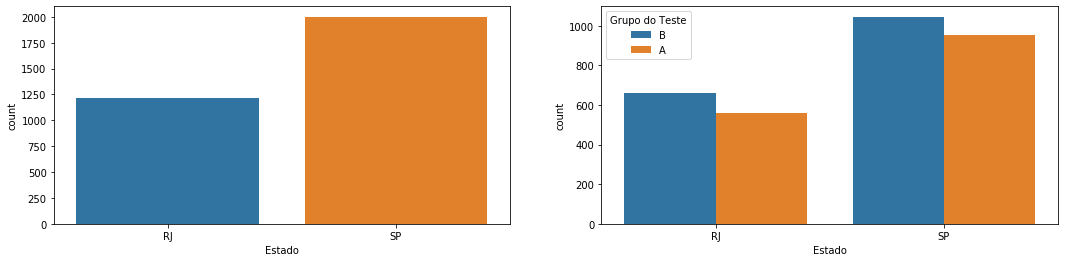

In [360]:
plt.figure(figsize=(18,4))
plt.subplot(1,2,1)
sns.countplot(x='Estado', data=df2)

plt.subplot(1,2,2)
sns.countplot(x='Estado', hue='Grupo do Teste', data=df2);
plt.savefig('media_conversao.png', format='png')
plt.show()

Conseguimos ver que as vendas para os clientes que receberam o frete fixo é maior, porém será que essa diferença é significativa?

## Quantidade de Clientes que efetuaram a compra

In [10]:
df_sp_grupoB = df2[(df2["Estado"]=="SP") & (df2['Grupo do Teste'] == "B")]
print ("A Quantidade de clientes de São Paulo que efetuaram a compra com frete fixo foi:", 
    len(df_sp_grupoB))

A Quantidade de clientes de São Paulo que efetuaram a compra com frete fixo foi: 1046


In [11]:
df_sp_grupoA = df2[(df2["Estado"]=="SP") & (df2['Grupo do Teste'] == "A")]
print ("A Quantidade de clientes de São Paulo que efetuaram a compra com frete variável:",len(df_sp_grupoA))

A Quantidade de clientes de São Paulo que efetuaram a compra com frete variável: 955


In [12]:
df_rj_grupoB = df2[(df2["Estado"]=="RJ") & (df2['Grupo do Teste'] == "B")]
print ("A Quantidade de clientes do Rio de Janeiro que efetuaram a compra com frete fixo foi:",len(df_rj_grupoB))

A Quantidade de clientes do Rio de Janeiro que efetuaram a compra com frete fixo foi: 661


In [13]:
df_rj_grupoA = df2[(df2["Estado"]=="RJ") & (df2['Grupo do Teste'] == "A")]
print ("A Quantidade de clientes do Rio de Janeiro que efetuaram a compra com frete variável foi:",len(df_rj_grupoA))

A Quantidade de clientes do Rio de Janeiro que efetuaram a compra com frete variável foi: 558


In [14]:
conversao_rj_a, conversao_rj_b = 558, 661
visitas_rj_a, visitas_rj_b = 26568, 26568
rate_rj_a, rate_rj_b = conversao_rj_a/visitas_rj_a, conversao_rj_b/visitas_rj_b


print('A Taxa de conversão no Rio de Janeiro para o produto A foi de: ',round(rate_rj_a*100,4))
print('A Taxa de conversão no Rio de Janeiro para o produto B foi de: ',round(rate_rj_b*100,4))

print("A taxa de conversão com o frete fixo é maior", round((rate_rj_b - rate_rj_a) / (rate_rj_a) * 100,2),"%")

A Taxa de conversão no Rio de Janeiro para o produto A foi de:  2.1003
A Taxa de conversão no Rio de Janeiro para o produto B foi de:  2.488
A taxa de conversão com o frete fixo é maior 18.46 %


In [15]:
conversao_sp_a, conversao_sp_b = 955, 1046
visitas_sp_a, visitas_sp_b = 44960, 44960
rate_sp_a, rate_sp_b = conversao_sp_a/visitas_sp_a, conversao_sp_b/visitas_sp_b

print('A Taxa de conversão em São Paulo para o produto A foi de: ',round(rate_sp_a*100,4))
print('A Taxa de conversão em São Paulo para o produto B foi de: ',round(rate_sp_b*100,4))

print("A taxa de conversão com o frete fixo é maior", round((rate_sp_b - rate_sp_a) / (rate_sp_a) * 100,2),"%")

A Taxa de conversão em São Paulo para o produto A foi de:  2.1241
A Taxa de conversão em São Paulo para o produto B foi de:  2.3265
A taxa de conversão com o frete fixo é maior 9.53 %


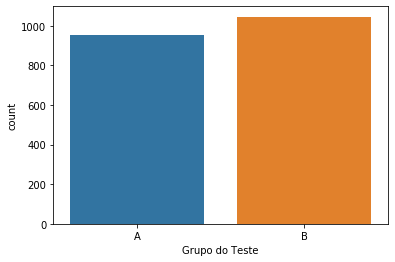

In [362]:
aux1 = df2[(df2["Estado"]=="SP")]
sns.countplot(x='Grupo do Teste', data =aux1);
plt.savefig('conversao_SP.png', format='png')
plt.show()

## Formulação das Hipóteses

- Hipótese Nula: H0. Não existe significância estatística
- Hipótese alternativa: H1. Existe significância estatística

In [16]:
# Criação de uma tabela com Valores de conversão e total de visitantes do Rio de Janeiro.
tabela_rj = np.array([[558,26010], [661,25907]])
tabela_sp = np.array([[955,44005], [1046,43914]])

In [17]:
# Criação de alpha - Nivéis de Significância.
# Exemplo: Um alpha de 0.05 significa que temos 95% de certeza de ser estatísticamente significante.
alpha = [0.1, 0.05, 0.01]

In [18]:
# Usando o Chi2 para descobrir o P_Value.
_, p_rj, _, _ = chi2_contingency(tabela_rj, correction=False)
print("O p_value para o Rio de Janeiro é:", p_rj)

O p_value para o Rio de Janeiro é: 0.0028402036030079165


In [19]:
_, p_sp, _, _ = chi2_contingency(tabela_sp, correction=False)
print("O p_value para São Paulo é:", p_sp)

O p_value para São Paulo é: 0.039654189205918254


In [20]:
for i in alpha:
    if i >= p_rj:
        print("Rejeite a Hipótese Nula para: ",i,"%")
    else:
        print("Aceite a Hipótese Nula para: ",i,"%")

Rejeite a Hipótese Nula para:  0.1 %
Rejeite a Hipótese Nula para:  0.05 %
Rejeite a Hipótese Nula para:  0.01 %


**Rejeitamos a hipótese nula para todos os níveis de significância: Podemos afirmar com 99% de certeza que existe significância estatística de que o frete fixo é melhor do que o frete variável no Rio de Janeiro.**

In [21]:
for i in alpha:
    if i >= p_sp:
        print("Rejeite a Hipótese Nula para: ",i,"%")
    else:
        print("Aceite a Hipótese Nula para: ",i,"%")

Rejeite a Hipótese Nula para:  0.1 %
Rejeite a Hipótese Nula para:  0.05 %
Aceite a Hipótese Nula para:  0.01 %


**Rejeitamos a hipótese nula para 0.1 e 0.05, porém aceitamos para 0.01: Isso significa que podemos afirmar com 90% e 95% de certeza que existe significância estatística de que o frete fixo é melhor do que o frete variável em São Paulo, Porém não conseguimos afirmar com 99% de certeza.**

## ROI

In [22]:
investimento_sp = df_sp_grupoB["Despesa de Frete"].sum()-df_sp_grupoB['Receita de Frete'].sum()
total_receita_produto_sp = df_sp_grupoB["Receita de Produto"].sum()

roi_sp = total_receita_produto_sp/investimento_sp
print("O Roi de São Paulo é: R$", roi_sp.round(2))

O Roi de São Paulo é: R$ 73.96


In [23]:
investimento_rj = df_rj_grupoB["Despesa de Frete"].sum()-df_rj_grupoB['Receita de Frete'].sum()
total_receita_produto_rj = df_rj_grupoB["Receita de Produto"].sum()

roi_rj = total_receita_produto_rj/investimento_rj
print("O Roi do Rio de Janeiro é: R$", roi_rj.round(2))

O Roi do Rio de Janeiro é: R$ 63.88


**O teste se mostrou positivo para ambos estados pois o Roi foi superior a 13 nos dois estados.**

# Pergunta 02

**Pergunta 02**

Identifique as variáveis que melhor explicam a probabilidade de o cliente fazer uma nova. Além disso, ordene os clientes da maior para menor probabilidade de fazer uma nova compra. Que ações poderiam ser feitas, com base nessas informações, visando a gerar valor ao negócio?

## Análise descritiva

In [283]:
df3.head()

,id_cliente_hash,QTD_PED_6M,QTD_PED_3M,QTD_PED_1M,APP_6M,MARKETPLACE_6M,TOP3_DEPTOS_6M,TIPO_PAG_MAIS_USADO_6M,C_CUPOM,C_APP,C_TIPO_PAGAMENTO,C_MARKETPLACE,C_DEPTO,F_RECOMPROU
0,-9222945220233620480,1.0,1.0,0.0,0.0,1.0,0.0,PAG5,0,0,PAG5,0,TOP_4_6,1
1,-9222163333197210624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,PAG5,0,OUTROS,1
2,-9221774094767413248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,PAG5,0,TOP_1_3,0
3,-9221309699803005952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,PAG5,0,OUTROS,1
4,-9218185772096892928,1.0,0.0,0.0,0.0,0.0,0.0,PAG5,0,0,PAG5,0,TOP_1_3,1


In [284]:
df3.shape

(21773, 14)

In [285]:
df3.isnull().sum()

id_cliente_hash               0
QTD_PED_6M                14734
QTD_PED_3M                14734
QTD_PED_1M                14734
APP_6M                    14734
MARKETPLACE_6M            14734
TOP3_DEPTOS_6M            14734
TIPO_PAG_MAIS_USADO_6M    14734
C_CUPOM                       0
C_APP                         0
C_TIPO_PAGAMENTO              0
C_MARKETPLACE                 0
C_DEPTO                       0
F_RECOMPROU                   0
dtype: int64

AS colunas "QTD_PED_6M", "QTD_PED_3M", "QTD_PED_1M", "APP_6M", "MARKETPLACE_6M", "TOP3_DEPTOS_6M", "TIPO_PAG_MAIS_USADO_6M" possuem mais de 67% de dados faltantes.

De acordo com o arquivo de apoio, esses dados faltantes são de clientes que não fizeram compras nos últimos 6 meses.

Vou preencher esses dados faltantes com o número 0.

In [286]:
# Preenchendo dados faltantes com 0.
df3.fillna(0, inplace=True)

In [287]:
df3.describe().T

,count,mean,std,min,25%,50%,75%,max
id_cliente_hash,21773.0,3.736008e+15,5.331059e+18,-9.222945e+18,-4.613682e+18,2.728040e+16,4.645679e+18,9.222632e+18
QTD_PED_6M,21773.0,8.500436e-01,2.253005e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,7.600000e+01
QTD_PED_3M,21773.0,4.614890e-01,1.333354e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.200000e+01
QTD_PED_1M,21773.0,1.844946e-01,6.195082e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.300000e+01
APP_6M,21773.0,1.827952e-02,1.339634e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
MARKETPLACE_6M,21773.0,5.332292e-02,2.246818e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
TOP3_DEPTOS_6M,21773.0,7.830800e-02,2.686618e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
C_CUPOM,21773.0,5.061314e-02,2.192115e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
C_APP,21773.0,2.691407e-02,1.618360e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
C_MARKETPLACE,21773.0,1.368208e-01,3.436660e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


In [288]:
# Não existe mais dados faltantes(Non-Null Count)
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21773 entries, 0 to 21772
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id_cliente_hash         21773 non-null  int64  
 1   QTD_PED_6M              21773 non-null  float64
 2   QTD_PED_3M              21773 non-null  float64
 3   QTD_PED_1M              21773 non-null  float64
 4   APP_6M                  21773 non-null  float64
 5   MARKETPLACE_6M          21773 non-null  float64
 6   TOP3_DEPTOS_6M          21773 non-null  float64
 7   TIPO_PAG_MAIS_USADO_6M  21773 non-null  object 
 8   C_CUPOM                 21773 non-null  int64  
 9   C_APP                   21773 non-null  int64  
 10  C_TIPO_PAGAMENTO        21773 non-null  object 
 11  C_MARKETPLACE           21773 non-null  int64  
 12  C_DEPTO                 21773 non-null  object 
 13  F_RECOMPROU             21773 non-null  int64  
dtypes: float64(6), int64(5), object(3)
mem

## Feature Engineering

In [289]:
df3['diferentes_formas_compra_6meses'] = df3['APP_6M']+df3['MARKETPLACE_6M']+df3['TOP3_DEPTOS_6M']

df3['diferentes_formas_compra_1mes'] = df3['C_APP']+df3['C_MARKETPLACE']

In [290]:
# Existem 3 colunas com dados categóricos:
df_cat_col = df3.select_dtypes(include='object')
df_num_col = df3.select_dtypes(exclude='object')

## Análise Exploratória

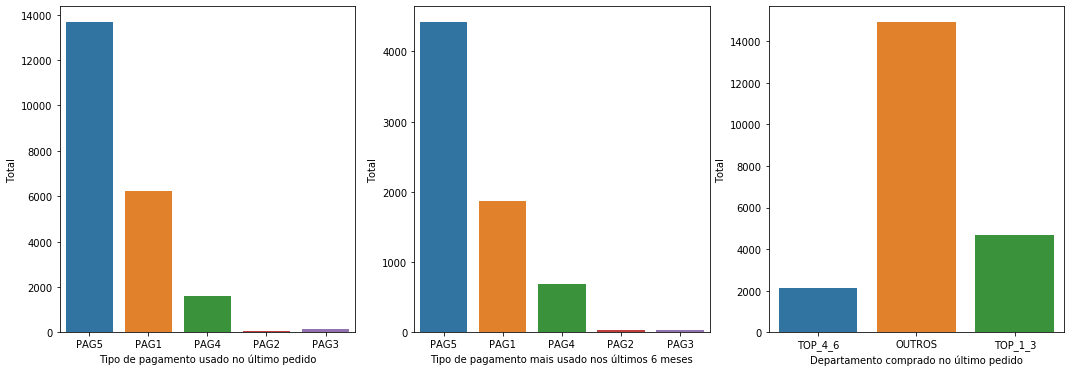

In [291]:
plt.figure(figsize=(18,6))
# Gráfico do tipo de pagamento usado no último pedido.
plt.subplot(1,3,1)
sns.countplot(x='C_TIPO_PAGAMENTO', data=df_cat_col);
plt.xlabel('Tipo de pagamento usado no último pedido'); plt.ylabel("Total");

# Gráfico do tipo de pagamento mais usado nos últimos 6 meses.
plt.subplot(1,3,2)
aux1 = df_cat_col[(df_cat_col['TIPO_PAG_MAIS_USADO_6M']!=0)]
sns.countplot(x='TIPO_PAG_MAIS_USADO_6M', data=aux1);
plt.xlabel('Tipo de pagamento mais usado nos últimos 6 meses'); plt.ylabel("Total");

# Departamento comprado no último pedido do cliente
plt.subplot(1,3,3)
sns.countplot(x='C_DEPTO', data=df_cat_col);
plt.xlabel('Departamento comprado no último pedido'); plt.ylabel("Total");

O tipo de pagamento mais usado é o PAG5

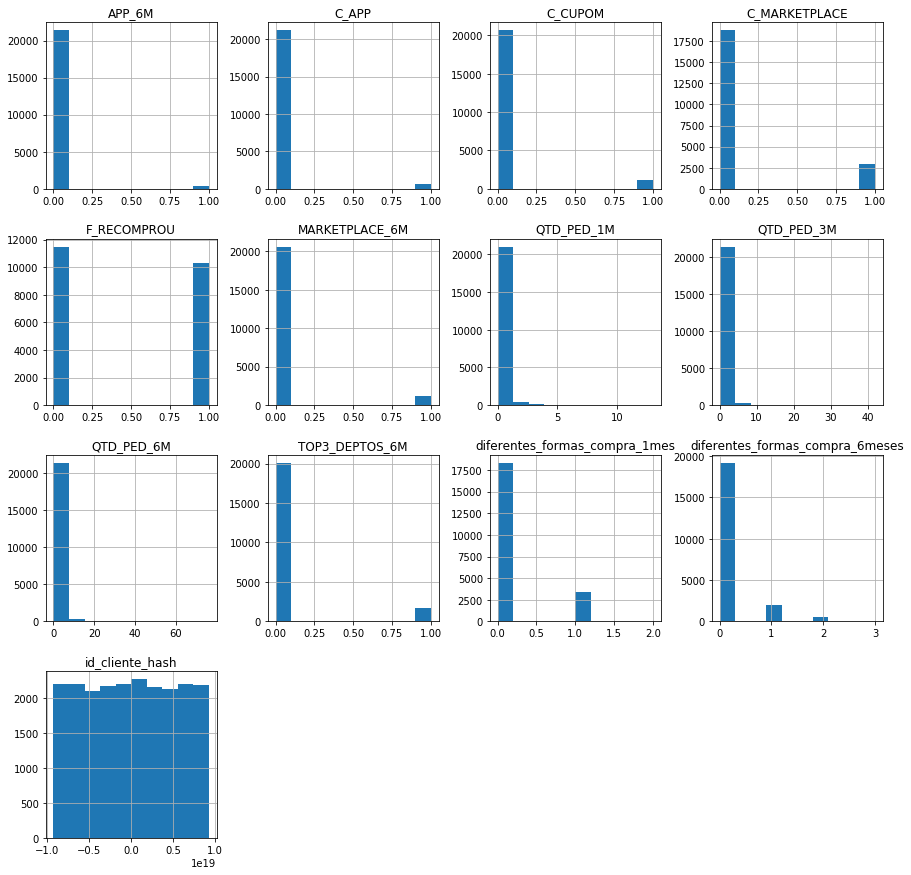

In [293]:
fig = plt.figure(figsize=(15,15))
ax = fig.gca()
df3.hist(ax=ax);

In [294]:
df3.columns

Index(['id_cliente_hash', 'QTD_PED_6M', 'QTD_PED_3M', 'QTD_PED_1M', 'APP_6M',
       'MARKETPLACE_6M', 'TOP3_DEPTOS_6M', 'TIPO_PAG_MAIS_USADO_6M', 'C_CUPOM',
       'C_APP', 'C_TIPO_PAGAMENTO', 'C_MARKETPLACE', 'C_DEPTO', 'F_RECOMPROU',
       'diferentes_formas_compra_6meses', 'diferentes_formas_compra_1mes'],
      dtype='object')

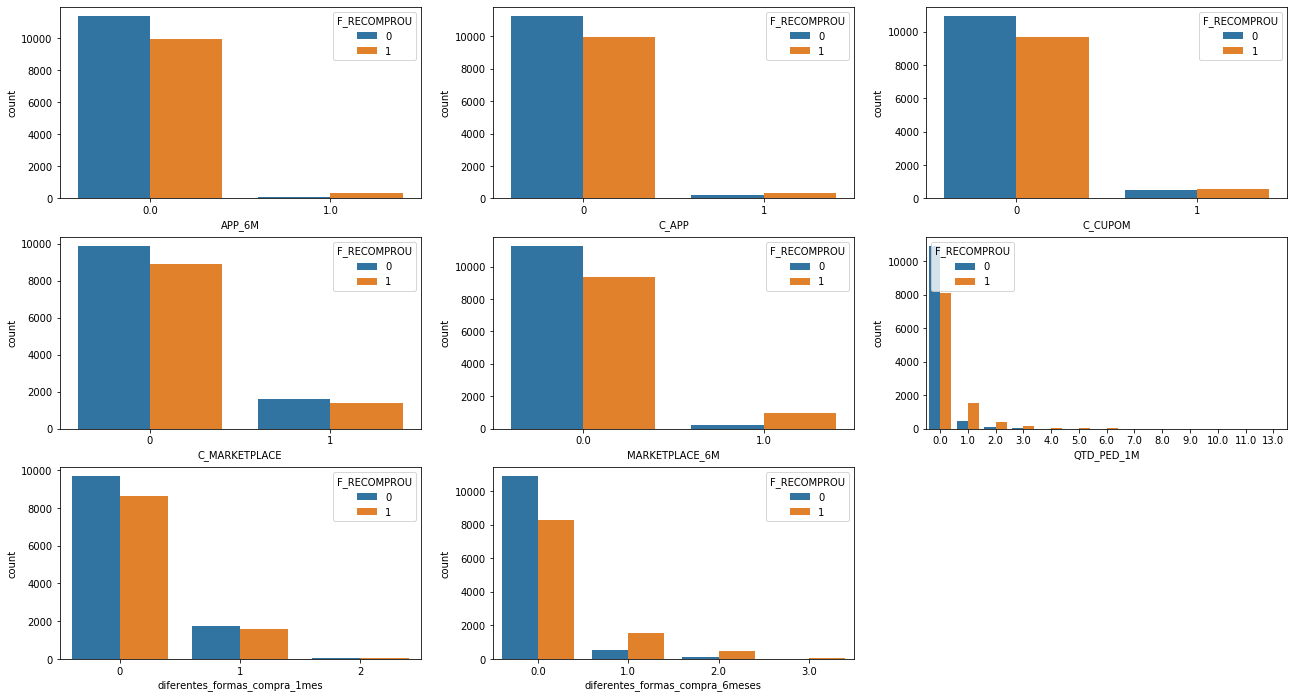

In [363]:
plt.figure(figsize=(22,12))
plt.subplot(3,3,1)
sns.countplot(x='APP_6M',hue='F_RECOMPROU', data=df3);


plt.subplot(3,3,2)
sns.countplot(x='C_APP',hue='F_RECOMPROU', data=df3);


plt.subplot(3,3,3)
sns.countplot(x='C_CUPOM',hue='F_RECOMPROU', data=df3);


plt.subplot(3,3,4)
sns.countplot(x='C_MARKETPLACE',hue='F_RECOMPROU', data=df3);


plt.subplot(3,3,5)
sns.countplot(x='MARKETPLACE_6M',hue='F_RECOMPROU', data=df3);


plt.subplot(3,3,6)
sns.countplot(x='QTD_PED_1M',hue='F_RECOMPROU', data=df3);


plt.subplot(3,3,7)
sns.countplot(x='diferentes_formas_compra_1mes',hue='F_RECOMPROU', data=df3);


plt.subplot(3,3,8)
sns.countplot(x='diferentes_formas_compra_6meses',hue='F_RECOMPROU', data=df3);




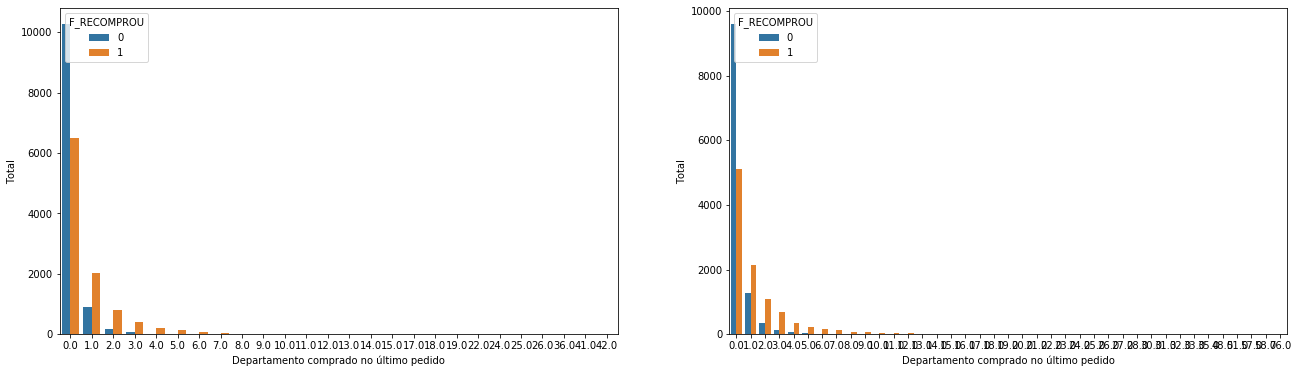

In [296]:
plt.figure(figsize=(22,6))
plt.subplot(1,2,1)
sns.countplot(x='QTD_PED_3M',hue='F_RECOMPROU', data=df3);
plt.xlabel('Departamento comprado no último pedido'); plt.ylabel("Total");

plt.subplot(1,2,2)
sns.countplot(x='QTD_PED_6M',hue='F_RECOMPROU', data=df3);
plt.xlabel('Departamento comprado no último pedido'); plt.ylabel("Total");

In [297]:
# Existem 4220 clientes  que não fizeram nenhum tipo de compra nós últimos 6 meses.
# Porém fizeram uma compra adicional em sua última compra.

df_shape = df3[(df3['APP_6M']==0) & (df3['C_APP']==0) & (df3['C_CUPOM']==0) & (df3['C_MARKETPLACE']==0) & 
    (df3['MARKETPLACE_6M']==0) & (df3['QTD_PED_1M']==0) & (df3['diferentes_formas_compra_1mes']==0) & 
    (df3['diferentes_formas_compra_6meses']==0) & (df3['QTD_PED_6M']==0) & (df3['F_RECOMPROU']==1)]
df_shape.shape

(4220, 16)

In [298]:
df_cat_col1 = pd.get_dummies(df_cat_col, drop_first=True)
df_final = pd.concat([df_num_col, df_cat_col1], axis=1)
df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
id_cliente_hash,21773.0,3.736008e+15,5.331059e+18,-9.222945e+18,-4.613682e+18,2.728040e+16,4.645679e+18,9.222632e+18
QTD_PED_6M,21773.0,8.500436e-01,2.253005e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,7.600000e+01
QTD_PED_3M,21773.0,4.614890e-01,1.333354e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.200000e+01
QTD_PED_1M,21773.0,1.844946e-01,6.195082e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.300000e+01
APP_6M,21773.0,1.827952e-02,1.339634e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
MARKETPLACE_6M,21773.0,5.332292e-02,2.246818e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
TOP3_DEPTOS_6M,21773.0,7.830800e-02,2.686618e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
C_CUPOM,21773.0,5.061314e-02,2.192115e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
C_APP,21773.0,2.691407e-02,1.618360e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
C_MARKETPLACE,21773.0,1.368208e-01,3.436660e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


## Normalização dos Dados

In [299]:
mm = MinMaxScaler()
rb = RobustScaler()

In [300]:
df_final['QTD_PED_6M'] = rb.fit_transform(df_final[['QTD_PED_6M']].values)

df_final['QTD_PED_3M'] = rb.fit_transform(df_final[['QTD_PED_3M']].values)

df_final['QTD_PED_1M'] = rb.fit_transform(df_final[['QTD_PED_1M']].values)

df_final['diferentes_formas_compra_6meses'] = mm.fit_transform(df_final[['diferentes_formas_compra_6meses']].values)

df_final['diferentes_formas_compra_1mes'] = mm.fit_transform(df_final[['diferentes_formas_compra_1mes']].values)

## Feature Importance

In [301]:
X = df_final.drop(['F_RECOMPROU'], axis=1)
y = df_final['F_RECOMPROU']

In [302]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1, stratify=y)

In [303]:
X_test.shape

(5444, 23)

In [304]:
X_train_copy = X_train.copy()
X_test_copy =  X_test.copy() 

In [305]:
X_train = X_train.drop(['id_cliente_hash'], axis=1)
X_test = X_test.drop(['id_cliente_hash'], axis=1)

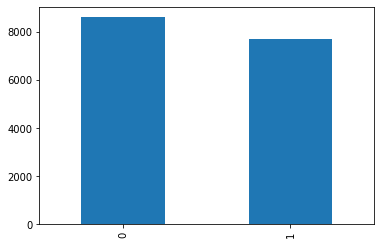

In [306]:
# Os dados não estão muito desbalanceado, dessa forma vou manter eles assim.
aux1 = y_train.value_counts()
aux1.plot.bar();

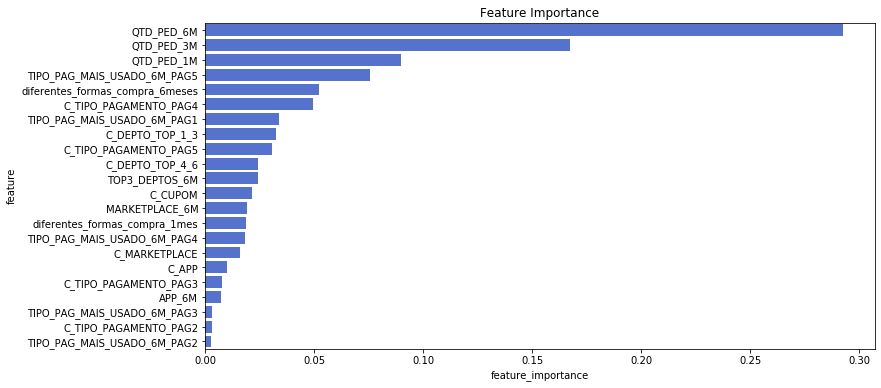

In [307]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# feature importance data frame
feat_imp = pd.DataFrame({'feature': X_train.columns,
                        'feature_importance': rf.feature_importances_})\
                        .sort_values('feature_importance', ascending=False)\
                        .reset_index(drop=True)


# plot feature importance
plt.subplots(figsize=(12,6))
sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', color='royalblue')\
    .set_title('Feature Importance');

In [308]:
X_train_fi = X_train[['QTD_PED_6M', 'QTD_PED_3M','QTD_PED_1M','TIPO_PAG_MAIS_USADO_6M_PAG5', 
                   'C_TIPO_PAGAMENTO_PAG4', 'diferentes_formas_compra_6meses']]

X_test_fi = X_test[['QTD_PED_6M', 'QTD_PED_3M','QTD_PED_1M','TIPO_PAG_MAIS_USADO_6M_PAG5', 
                   'C_TIPO_PAGAMENTO_PAG4', 'diferentes_formas_compra_6meses']]

As variavéis mais importantes para o meu modelo prever são: 'QTD_PED_6M', 'QTD_PED_3M', 'QTD_PED_1M', 'TIPO_PAG_MAIS_USADO_6M_PAG5', 'C_TIPO_PAGAMENTO_PAG4', 'diferentes_formas_compra_6meses'.

## Machine Learning

### Instânciando Modelos

In [309]:
# Dividindo em folds e instânciando os modelos.
kfold=5
du = DummyClassifier()
lr = LogisticRegression()
dtc = DecisionTreeClassifier()
etx = ExtraTreesClassifier()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()
xbc = XGBClassifier()
rdg = RidgeClassifier()

### Dummy - Classificador Aleatório - Todas variavéis

In [310]:
du_result = ml_error('Dummy Classifier', du)
du_result

,Model_Name,Acuracia,Precision,Recall,ROC_AUC,Precision-Recall
0,Dummy Classifier,0.489803,0.45947,0.456867,0.498001,0.471148


### Regressão Logística - Todas variavéis

In [311]:
lr_result = ml_error('Regressão Logistica',lr)
lr_result

,Model_Name,Acuracia,Precision,Recall,ROC_AUC,Precision-Recall
0,Regressão Logistica,0.681915,0.724315,0.526786,0.710317,0.705737


### DecisionTreeClassifier - Todas variavéis

In [312]:
dtc_result = ml_error('DecisionTreeClassifier',dtc)
dtc_result

,Model_Name,Acuracia,Precision,Recall,ROC_AUC,Precision-Recall
0,DecisionTreeClassifier,0.659623,0.726013,0.448046,0.672475,0.656881


### ExtraTreesClassifier - Todas variavéis

In [313]:
etx_result = ml_error('ExtraTreesClassifier',etx)
etx_result

,Model_Name,Acuracia,Precision,Recall,ROC_AUC,Precision-Recall
0,ExtraTreesClassifier,0.666421,0.730688,0.46478,0.685781,0.662805


### RandonForestClassifier - Todas variavéis

In [314]:
rfc_result = ml_error('RandomForestClassifier',rfc)
rfc_result

,Model_Name,Acuracia,Precision,Recall,ROC_AUC,Precision-Recall
0,RandomForestClassifier,0.671198,0.729456,0.482551,0.692199,0.674217


### GradientBoostingClassifier - Todas variavéis

In [315]:
gbc_result = ml_error('GradientBoostingClassifier',gbc)
gbc_result

,Model_Name,Acuracia,Precision,Recall,ROC_AUC,Precision-Recall
0,GradientBoostingClassifier,0.681058,0.720916,0.52925,0.710589,0.706217


### XgBoost - Todas variavéis

In [316]:
xbc_result = ml_error('XGBClassifier',xbc)
xbc_result

,Model_Name,Acuracia,Precision,Recall,ROC_AUC,Precision-Recall
0,XGBClassifier,0.674995,0.724928,0.50253,0.704083,0.695883


### RidgeClassifier - Todas variavéis

In [317]:
ridge_result = ml_error('RidgeClassifier',rdg)
ridge_result

,Model_Name,Acuracia,Precision,Recall,ROC_AUC,Precision-Recall
0,RidgeClassifier,0.681303,0.725853,0.522116,0.708413,0.697444


### Comparação de Modelos - Todas variavéis

In [318]:
modelling_result = pd.concat([du_result, lr_result,dtc_result,etx_result,rfc_result,gbc_result,xbc_result, ridge_result])
modelling_result.sort_values('Precision-Recall', ascending=False)

,Model_Name,Acuracia,Precision,Recall,ROC_AUC,Precision-Recall
0,GradientBoostingClassifier,0.681058,0.720916,0.529250,0.710589,0.706217
0,Regressão Logistica,0.681915,0.724315,0.526786,0.710317,0.705737
0,RidgeClassifier,0.681303,0.725853,0.522116,0.708413,0.697444
0,XGBClassifier,0.674995,0.724928,0.502530,0.704083,0.695883
0,RandomForestClassifier,0.671198,0.729456,0.482551,0.692199,0.674217
0,ExtraTreesClassifier,0.666421,0.730688,0.464780,0.685781,0.662805
0,DecisionTreeClassifier,0.659623,0.726013,0.448046,0.672475,0.656881
0,Dummy Classifier,0.489803,0.459470,0.456867,0.498001,0.471148


### Variavéis escolhidas por feature importance

In [319]:
du_result = ml_error_fi('Dummy Classifier', du)
du_result

,Model_Name,Acuracia,Precision,Recall,ROC_AUC,Precision-Recall
0,Dummy Classifier,0.50052,0.471156,0.473732,0.498145,0.47122


In [320]:
lr_result = ml_error_fi('Regressão Logistica',lr)
lr_result

,Model_Name,Acuracia,Precision,Recall,ROC_AUC,Precision-Recall
0,Regressão Logistica,0.676342,0.729072,0.500453,0.6912,0.667926


In [321]:
dtc_result = ml_error_fi('DecisionTreeClassifier',dtc)
dtc_result

,Model_Name,Acuracia,Precision,Recall,ROC_AUC,Precision-Recall
0,DecisionTreeClassifier,0.673831,0.715224,0.513554,0.679899,0.649197


In [322]:
etx_result = ml_error_fi('ExtraTreesClassifier',etx)
etx_result

,Model_Name,Acuracia,Precision,Recall,ROC_AUC,Precision-Recall
0,ExtraTreesClassifier,0.676342,0.717003,0.519392,0.68371,0.651573


In [323]:
rfc_result = ml_error_fi('RandomForestClassifier',rfc)
rfc_result

,Model_Name,Acuracia,Precision,Recall,ROC_AUC,Precision-Recall
0,RandomForestClassifier,0.678669,0.718545,0.524969,0.68509,0.653233


In [324]:
gbc_result = ml_error_fi('GradientBoostingClassifier',gbc)
gbc_result

,Model_Name,Acuracia,Precision,Recall,ROC_AUC,Precision-Recall
0,GradientBoostingClassifier,0.682773,0.720751,0.535476,0.6906,0.667645


In [325]:
xbc_result = ml_error_fi('XGBClassifier',xbc)
xbc_result

,Model_Name,Acuracia,Precision,Recall,ROC_AUC,Precision-Recall
0,XGBClassifier,0.681241,0.720046,0.531325,0.689626,0.66481


In [326]:
ridge_result = ml_error_fi('RidgeClassifier',rdg)
ridge_result

,Model_Name,Acuracia,Precision,Recall,ROC_AUC,Precision-Recall
0,RidgeClassifier,0.665687,0.737345,0.453365,0.686596,0.651663


In [327]:
modelling_result = pd.concat([du_result, lr_result,dtc_result,etx_result,rfc_result,gbc_result,xbc_result, ridge_result])
modelling_result.sort_values('Precision-Recall', ascending=False)

,Model_Name,Acuracia,Precision,Recall,ROC_AUC,Precision-Recall
0,Regressão Logistica,0.676342,0.729072,0.500453,0.691200,0.667926
0,GradientBoostingClassifier,0.682773,0.720751,0.535476,0.690600,0.667645
0,XGBClassifier,0.681241,0.720046,0.531325,0.689626,0.664810
0,RandomForestClassifier,0.678669,0.718545,0.524969,0.685090,0.653233
0,RidgeClassifier,0.665687,0.737345,0.453365,0.686596,0.651663
0,ExtraTreesClassifier,0.676342,0.717003,0.519392,0.683710,0.651573
0,DecisionTreeClassifier,0.673831,0.715224,0.513554,0.679899,0.649197
0,Dummy Classifier,0.500520,0.471156,0.473732,0.498145,0.471220


### Análise

**Não existe uma difrença muito grande entre os resultados com todas as variavéis ou com o resultado com as variavéis do Feature importance. Por isto irei usar apenas as variavéis que o Feature Importance indicou pois um modelo mais simples é mais generalizado**

### Hyperparameter Fine-Tuning - Regression Logistic

In [328]:
param_grid = [{'penalty':['l1', 'l2', 'elasticnet'], 'tol':[0.0001, 0.001, 0.01]}]
grid = RandomizedSearchCV(lr, param_grid, cv=kfold)
grid.fit(X_train_fi,y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions=[{'penalty': ['l1', 'l2', 'elasticnet'],
                                         'tol': [0.0001, 0.001, 0.01]}],
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=

In [329]:
grid.best_params_

{'tol': 0.0001, 'penalty': 'l2'}

### Resultados Regression Logistic

In [330]:
lr.fit(X_train_fi, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [331]:
y_pred = lr.predict(X_test_fi)

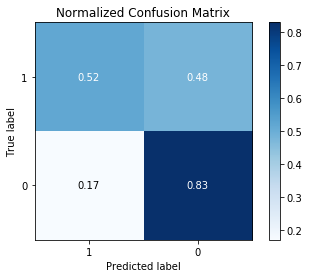

In [332]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred,normalize=True,labels=[1,0]);

In [333]:
recall = recall_score(y_test, y_pred).round(2)*100
precision = precision_score(y_test, y_pred).round(2)*100

print("De todos os Clientes que foi previsto que fariam compra adicional, o modelo acertou:", precision, '%')
print("De todos os Clientes que efetivamente fizeram uma compra adicional, o modelo acertou:", recall, '%')

De todos os Clientes que foi previsto que fariam compra adicional, o modelo acertou: 73.0 %
De todos os Clientes que efetivamente fizeram uma compra adicional, o modelo acertou: 52.0 %


## Análise

**Como os dois modelos tiveram performance parecida, o ideal seria usar o modelo de Regressão Logística ao modelo de GradienteBoosting pois o modelo mais simples é o modelo que tem mais capacidade de generalização.**

## Predição de Probabilidades

In [343]:
y_pred_proba = lr.predict_proba(X_test_fi)[:,1]

y_pred_proba = y_pred_proba.round(2)

y_pred_proba = pd.DataFrame(y_pred_proba)

X_test_copy = X_test_copy['id_cliente_hash'].reset_index()

df_proba = pd.concat([X_test_copy, y_pred_proba], axis=1)

df_proba.columns = ['index', 'id_cliente', 'probabilidade']

In [348]:
df_proba = df_proba.sort_values('probabilidade', ascending=False)

In [349]:
df_proba

,index,id_cliente,probabilidade
311,311,-9017233728380773376,1.00
4362,4362,-2889174536654586368,1.00
2296,2296,9059087813476462592,1.00
1679,1679,6858252281312719872,1.00
1776,1776,3995984459686725632,1.00
...,...,...,...
1317,1317,4321565155456569856,0.35
3116,3116,328259338995055040,0.35
3117,3117,7126509576126911488,0.35
1316,1316,-6470902821264287744,0.35
